# German credit fraud

http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff

Professor Dr. Hans Hofmann

Institut fur Statistik und Okonometrie Universitat Hamburg  
FB Wirtschaftswissenschaften  
Von-Melle-Park 5    
2000 Hamburg 13

# Exploratory data analysis
1. [Data import and summary](#Data-import-and-summary)
- [Data preparation](#Data-preparation)
- [Correlation analysis](#Correlation-analysis)
- [Feature creation and selection](#Feature-creation-and-selection)

1. Remove the depiction against the output (Y) in `plot_categorical`
- Try visualizing all variables at once (alternatively, group them by ordinal/cardinal/continuous)
- Perform PCA/CA/t-SNE etc

---

## Data import and summary

In [1]:
%%html
<link rel="stylesheet" href="custom.css"/>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from utils import plot_categorical

In [3]:
df = pd.read_csv('data/german-credit.csv')
df.head()

,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,location,personal_status,other_parties,...,property_magnitude,cc_age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
df.shape

(1000, 21)

In [5]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
credit_usage,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
current_balance,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
location,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
cc_age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [6]:
df.describe(include='O').T

,count,unique,top,freq
over_draft,1000,4,'no checking',394
credit_history,1000,5,'existing paid',530
purpose,1000,10,radio/tv,280
Average_Credit_Balance,1000,5,'<100',603
employment,1000,5,'1<=X<4',339
personal_status,1000,4,'male single',548
other_parties,1000,3,none,907
property_magnitude,1000,4,car,332
other_payment_plans,1000,3,none,814
housing,1000,3,own,713


There doesn't seem to be any obviously missing data.

In [7]:
df.isna().sum()

over_draft                0
credit_usage              0
credit_history            0
purpose                   0
current_balance           0
Average_Credit_Balance    0
employment                0
location                  0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
cc_age                    0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

### **class**
Output (categorical, binary)

In [8]:
df['class'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: class, dtype: float64

As we see, the output contains no missing values and is slightly imbalanced.

Let us now split the dataset into training and test subsets so we carry all the below analysis on the training part and leave the test one for prediction.

In [9]:
# import gc
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['class'])
# train.to_csv('data/train.csv', index=False)
# test.to_csv('data/test.csv', index=False)

# # Now free up the memory (is not guaranteed to work)
# del df, train, test
# gc.collect()

In [10]:
df = pd.read_csv('data/train.csv')

In [11]:
output = df['class'].map({'good': 0, 'bad': 1})
df.drop('class', axis=1, inplace=True)

---

## Data preparation

We will start-off with the variables requiring special transformations and carry on with the rest after that.

In [12]:
import sklearn.preprocessing as pp
from sklearn.impute import MissingIndicator
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

### **over_draft**
Status of existing [checking account](https://en.wikipedia.org/wiki/Transaction_account) (categorical, mixed).

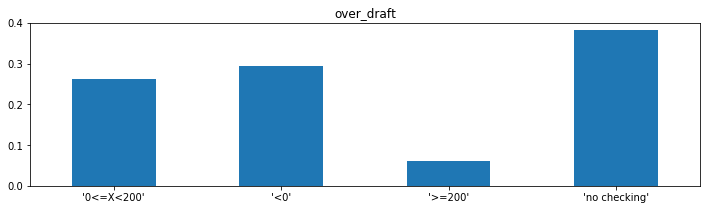

In [13]:
plot_categorical(df['over_draft'])

`'no checking'` does not fit the ordinal nature of the feature and should be extracted.

In [14]:
(df['over_draft'] == "'no checking'").value_counts(normalize=True)

False    0.618571
True     0.381429
Name: over_draft, dtype: float64

In [15]:
over_draft = pp.OrdinalEncoder([["'no checking'", "'<0'", "'0<=X<200'", "'>=200'"]])

### **credit_usage**
Duration in months (categorical, cardinal), alternatively - (numeric, integer).

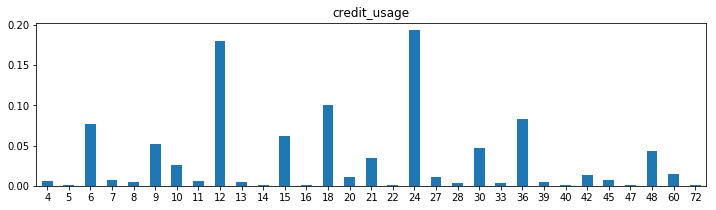

In [16]:
plot_categorical(df['credit_usage'])

If one decides to treat the feature as categorical, one can say that it demonstrates high cardinality and the levels are better be fused (collapsed) in order to reduce the effect. E.g. low-frequency levels can be merged into those that rise above, say, the 5% threshold.

If, otherwise, one decides to treat the feature as integer, nothing really needs to be done apart from simple scaling.

Being aware of the [negative effects of fusion (binning)](http://biostat.mc.vanderbilt.edu/wiki/Main/CatContinuous), we'll go the long way here to indicate that any cut points an algorithm could come up with other than those at the highly represented levels would be considered as overfitting.

In [17]:
class ThresholdBinner(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X):
        counts = X.iloc[:,0].value_counts(normalize=True).sort_index()
        self.max_value = counts.index.max()
        self.above_threshold = counts[counts >= self.threshold].index.values
        return self

    def transform(self, X):
        def mapper(x):
            for i in self.above_threshold:
                if x <= i:
                    return i
            return self.max_value
        return X.iloc[:,0].apply(mapper).values.reshape(-1, 1)

In [18]:
credit_usage = ThresholdBinner(0.05)

Let's check out what we've achieved with the above.

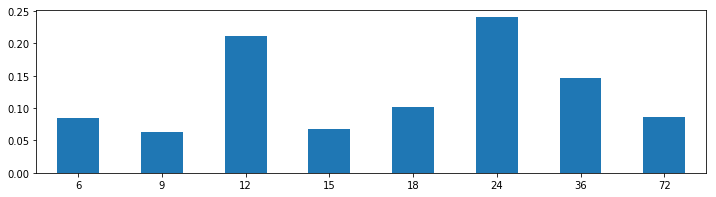

In [19]:
plot_categorical(pd.Series(credit_usage.fit_transform(df[['credit_usage']]).reshape(-1)))

### **credit_history**
Credit history (categorical, nominal).

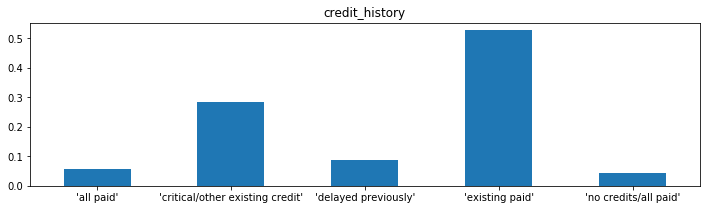

In [20]:
plot_categorical(df['credit_history'])

As we can see the underlying meaning of some of the levels is the same so we'll proceed with collapsing the levels accordingly to reduce dimensionality by applying domain knowledge.

In [21]:
class NominalMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapper):
        self.mapper = mapper

    def fit(self, X):
        return self

    def transform(self, X):
        return X.iloc[:,0].apply(self.mapper).values.reshape(-1, 1)

In [22]:
def mapper(x):
    if x in ["'existing paid'", "'no credits/all paid'", "'all paid'"]:
        return 'paid'
    elif x == "'critical/other existing credit'":
        return 'other_exist'
    elif x == "'delayed previously'":
        return 'delayed'
    else:
        return x

credit_history_map = NominalMapper(mapper)

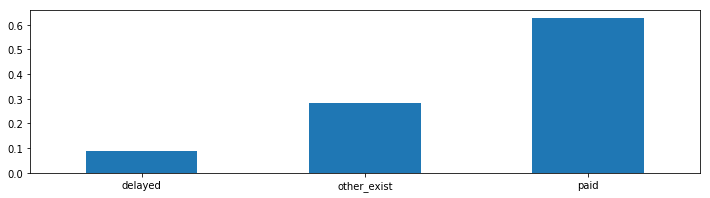

In [23]:
plot_categorical(pd.Series(credit_history_map.fit_transform(df[['credit_history']]).reshape(-1)))

In [24]:
credit_history = make_pipeline(credit_history_map, pp.OneHotEncoder())

### **purpose**
Loan purpose (categorical, nominal).

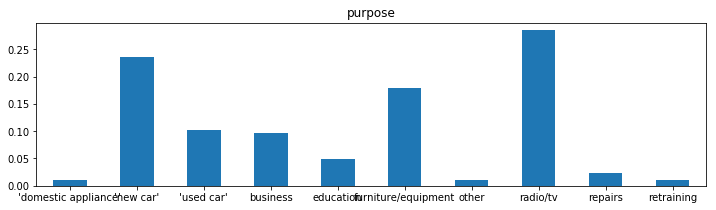

In [25]:
plot_categorical(df['purpose'])

In [26]:
def mapper(x):
    if x == 'furniture/equipment':
        return 'furniture'
    elif x == 'retraining':
        return 'education'
    elif x in ['repairs', "'domestic appliance'"]:
        return 'other'
    elif x == "'new car'":
        return 'new_car'
    elif x == "'used car'":
        return 'used_car'
    else:
        return x

purpose_map = NominalMapper(mapper)

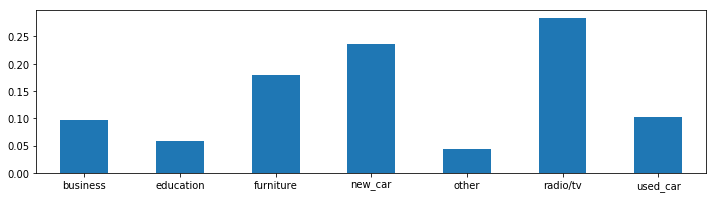

In [27]:
plot_categorical(pd.Series(purpose_map.fit_transform(df[['purpose']]).reshape(-1)))

In [28]:
purpose = make_pipeline(purpose_map, pp.OneHotEncoder())

### **Average_Credit_Balance**
Savings account/bonds (categorical, ordinal).

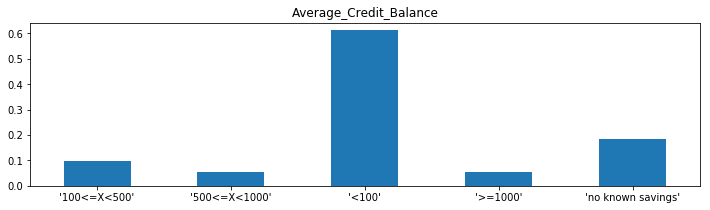

In [29]:
plot_categorical(df['Average_Credit_Balance'])

In [30]:
acb = pp.OrdinalEncoder([["'no known savings'", "'<100'", "'100<=X<500'", "'500<=X<1000'", "'>=1000'"]])

### **employment**
Present employment since, years (categorical, ordinal).

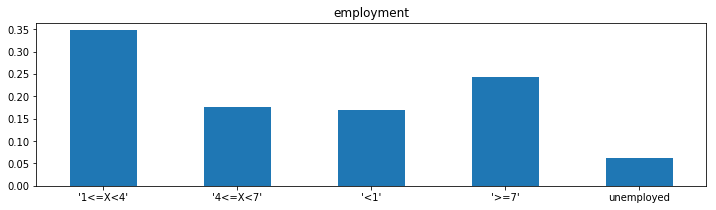

In [31]:
plot_categorical(df['employment'])

In [32]:
employment = pp.OrdinalEncoder([['unemployed', "'<1'", "'1<=X<4'", "'4<=X<7'", "'>=7'"]])

### **personal_status**
Personal status and sex (categorical, compound).

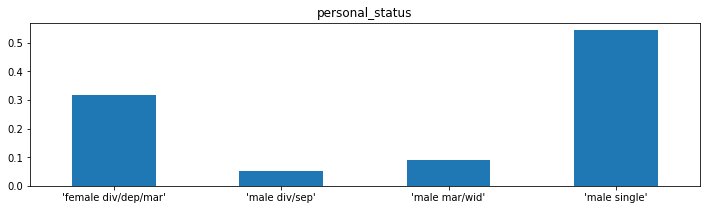

In [33]:
plot_categorical(df['personal_status'])

The feature seems like a mixture of `sex` and `marital status` but it really isn't since only one categorical level is attributed to females. Nevertheless, we will split this column into two anyway for illustrative purposes.

In [34]:
def mapper_sex(x):
    if x == "'female div/dep/mar'":
        return 'female'
    else:
        return 'male'
    
status_sex = make_pipeline(NominalMapper(mapper_sex), pp.OneHotEncoder())

In [35]:
def mapper_status(x):
    if x == "'male single'":
        return 'single'
    elif x == "'male div/sep'":
        return 'div/sep'
    elif x == "'male mar/wid'":
        return 'mar/wid'
    else:
        return x

status_married = make_pipeline(NominalMapper(mapper_status), pp.OneHotEncoder())

### **job**
Employment status (categorical, nominal).

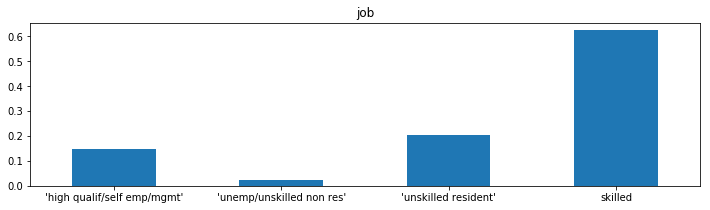

In [36]:
plot_categorical(df['job'])

In [37]:
def mapper(x):
    if x in ["'unskilled resident'", "'unemp/unskilled non res'"]:
        return 'unskilled'
    else:
        return x

job = make_pipeline(NominalMapper(mapper), pp.OneHotEncoder())

### **current_balance, cc_age**
Continuous numeric variables that do not require any special treatment (apart from the obvious scaling down below).  
We report `cc_age` as pseudo continuous here despite what we did to `credit_usage` earlier on.

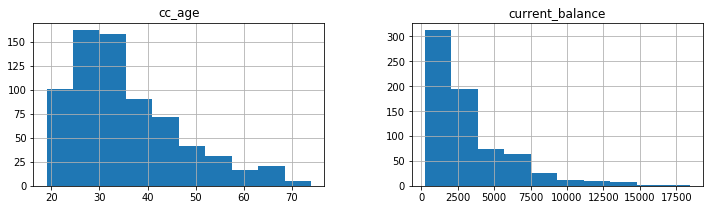

In [38]:
df[['current_balance', 'cc_age']].hist(figsize=(12, 3));

### **location, residence_since, existing_credits, num_dependents**
Relatively well-behaved categorical ordinal variables that do not require any immediate treatment.

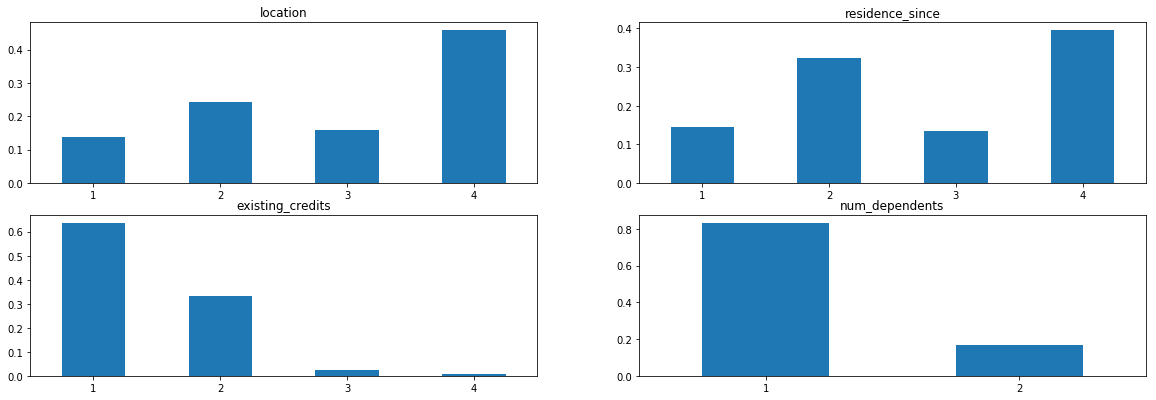

In [39]:
cols = ['location','residence_since', 'existing_credits', 'num_dependents']
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 6.5))
for col, ax in zip(cols, axes.flatten()):
    plot_categorical(df[col], ax)

### **other_parties, property_magnitude, other_payment_plans, housing, own_telephone, foreign_worker**
Relatively well-behaved categorical nominal variables that do not require any immediate treatment.

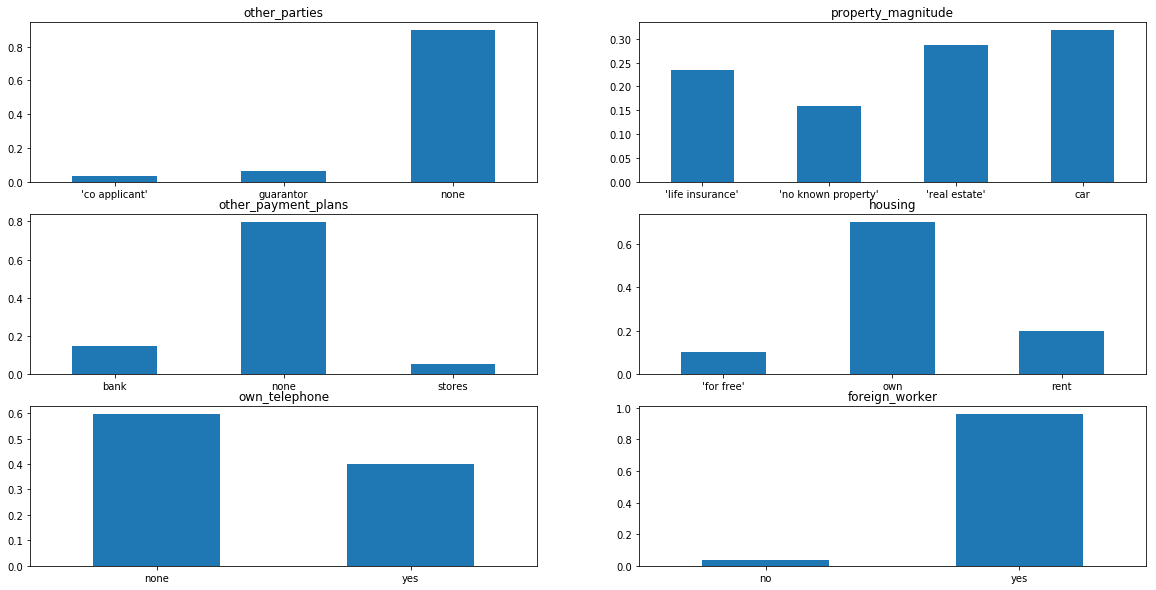

In [40]:
cols = ['other_parties', 'property_magnitude',
        'other_payment_plans', 'housing',
        'own_telephone', 'foreign_worker']
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
for col, ax in zip(cols, axes.flatten()):
    plot_categorical(df[col], ax)

---

## Pipeline

In [41]:
ct = make_column_transformer((over_draft, ['over_draft']),
                             (credit_usage, ['credit_usage']),
                             (credit_history, ['credit_history']),
                             (purpose, ['purpose']),
                             (acb, ['Average_Credit_Balance']),
                             (employment, ['employment']),
                             (status_sex, ['personal_status']),
                             (status_married, ['personal_status']),
                             (job, ['job']),
                             (pp.OneHotEncoder(), ['other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing',
                                                   'own_telephone',
                                                   'foreign_worker']),
                             remainder='passthrough')

In [42]:
pipeline =  Pipeline([('transform', ct), ('scale', pp.StandardScaler())])
prep = pipeline.fit_transform(df)

In [43]:
df_prep = pd.DataFrame(prep)
df_prep.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.055466,-0.327602,-0.311735,-0.628031,0.768706,3.048626,-0.249430,-0.466252,-0.555348,-0.215262,...,-1.221107,1.221107,-0.19245,0.19245,-0.476252,0.948917,-0.697911,-0.037214,-0.702693,-0.44798
1,-1.064552,2.792417,-0.311735,-0.628031,0.768706,3.048626,-0.249430,-0.466252,-0.555348,-0.215262,...,-1.221107,1.221107,-0.19245,0.19245,0.558181,0.053712,-0.697911,-0.212632,-0.702693,-0.44798
2,-1.064552,-1.020940,-0.311735,-0.628031,0.768706,-0.328017,-0.249430,-0.466252,-0.555348,-0.215262,...,0.818929,-0.818929,-0.19245,0.19245,-0.983314,0.053712,-1.591034,-0.563469,-0.702693,-0.44798
3,1.055466,2.792417,3.207853,-0.628031,-1.300887,-0.328017,4.009136,-0.466252,-0.555348,-0.215262,...,-1.221107,1.221107,-0.19245,0.19245,3.022578,-0.841493,0.195211,-0.300341,-0.702693,-0.44798
4,-0.004543,0.019067,-0.311735,-0.628031,0.768706,-0.328017,-0.249430,-0.466252,-0.555348,-0.215262,...,0.818929,-0.818929,-0.19245,0.19245,-0.477321,0.948917,0.195211,-0.300341,-0.702693,-0.44798


In [44]:
df_prep.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
0,700.0,3.172066e-18,1.000715,-1.064552,-1.064552,-0.004543,1.055466,2.115475
1,700.0,-1.145760e-16,1.000715,-1.020940,-0.674271,-0.327602,0.019067,2.792417
2,700.0,-5.011864e-17,1.000715,-0.311735,-0.311735,-0.311735,-0.311735,3.207853
3,700.0,-1.278343e-16,1.000715,-0.628031,-0.628031,-0.628031,1.592279,1.592279
4,700.0,-8.374254e-17,1.000715,-1.300887,-1.300887,0.768706,0.768706,0.768706
5,700.0,3.444863e-16,1.000715,-0.328017,-0.328017,-0.328017,-0.328017,3.048626
6,700.0,1.138772e-16,1.000715,-0.249430,-0.249430,-0.249430,-0.249430,4.009136
7,700.0,-5.233909e-18,1.000715,-0.466252,-0.466252,-0.466252,-0.466252,2.144761
8,700.0,-2.139558e-16,1.000715,-0.555348,-0.555348,-0.555348,-0.555348,1.800673
9,700.0,-8.746971e-17,1.000715,-0.215262,-0.215262,-0.215262,-0.215262,4.645497


---

## Analysis

### Correlation

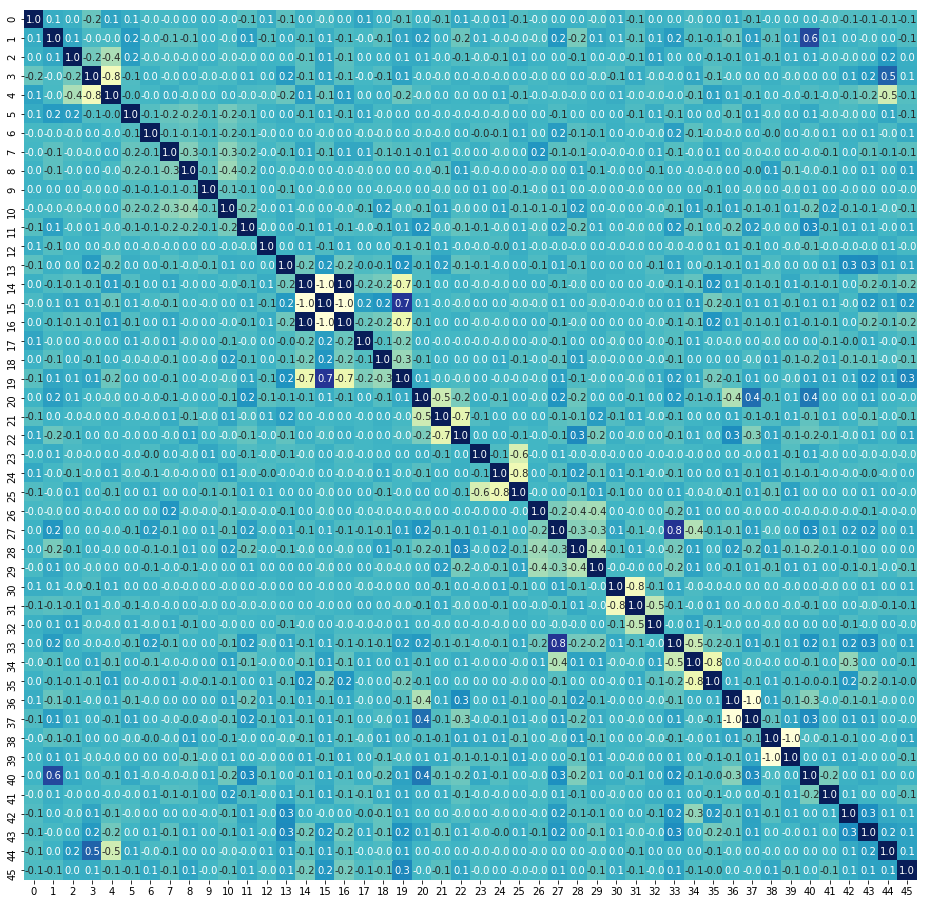

In [45]:
import seaborn as sb

plt.figure(figsize=(16, 16))
sb.heatmap(df_prep.corr(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

---

In [46]:
df_prep.to_csv('data/german-credit-prep.csv', index=False)